In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Final Dataset

In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,2,3
1,2,upgraded card tell agent upgrade anniversary d...,5,1
2,10,chase card report however fraudulent applicati...,2,3
3,11,try book ticket come across offer apply toward...,5,3
4,14,grand son give check deposit chase account fun...,6,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,5,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,3,2
21070,78311,flawless credit chase credit card chase freedo...,4,3


# TF-IDF text representation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(21072, 16306)

In [4]:
vectorizer.get_feature_names_out()

array(['aad', 'aba', 'abandon', ..., 'zoom', 'zur', 'zyk'], dtype=object)

# Data Partition

In [5]:
# split into training set and validation set
from sklearn.model_selection import train_test_split

y = df[['topic_lda','priority']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 16306)
(4215, 16306)
(16857, 2)
(4215, 2)


# Model Building

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

rf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train, y_train)
rf.score(X_test,y_test)

0.4443653618030842

In [8]:
rf_preds = rf.predict(X_test)

In [9]:
rf_preds

array([[8, 3],
       [8, 3],
       [7, 3],
       ...,
       [0, 3],
       [0, 3],
       [8, 3]], dtype=int64)

In [10]:
rf_preds[:, 0]

array([8, 8, 7, ..., 0, 0, 8], dtype=int64)

In [11]:
rf_preds[:, 1]

array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

# Evaluation

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.7141162514827996
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       835
           1       0.84      0.53      0.65       371
           2       0.88      0.52      0.65       368
           3       0.73      0.05      0.09       161
           4       0.86      0.44      0.58       262
           5       0.86      0.64      0.73       380
           6       0.67      0.88      0.76       669
           7       0.75      0.69      0.72       281
           8       0.64      0.79      0.71       888

    accuracy                           0.71      4215
   macro avg       0.77      0.61      0.63      4215
weighted avg       0.74      0.71      0.70      4215



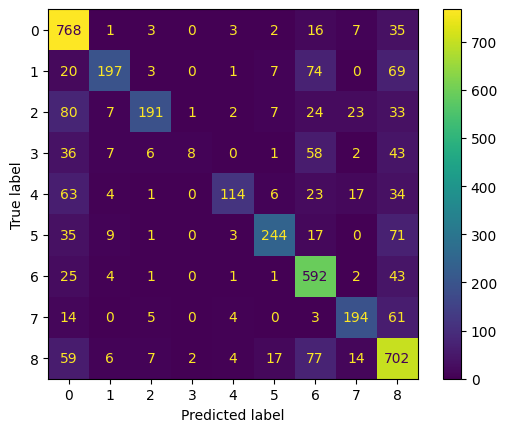

In [13]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=rf_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], rf_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=rf_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.6158956109134045
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.20      0.31       805
           2       0.60      0.35      0.44      1282
           3       0.61      0.93      0.74      2128

    accuracy                           0.62      4215
   macro avg       0.65      0.49      0.50      4215
weighted avg       0.63      0.62      0.57      4215



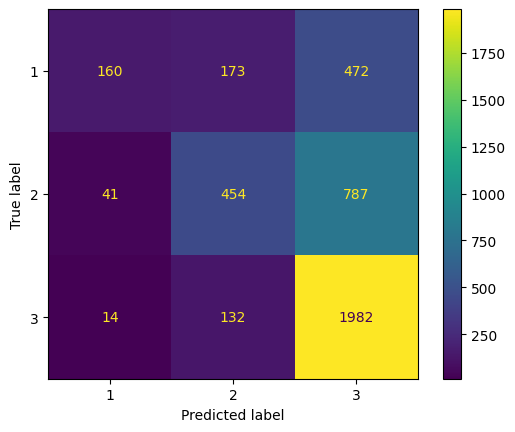

In [14]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=rf_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], rf_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=rf_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [16]:
param_grid = {
    "estimator__n_estimators": np.linspace(100,1000, 10).astype(int),
    "estimator__min_samples_split": np.linspace(0.01, 0.05, 5),
    "estimator__min_samples_leaf": np.linspace(0.005, 0.025, 5),
    "estimator__max_depth":[10,20,50],
    "estimator__max_leaf_nodes":[5,10,50,100]
}

In [17]:
random_search = RandomizedSearchCV(
    estimator=MultiOutputClassifier(RandomForestClassifier(random_state=42)), 
    param_distributions=param_grid, 
    n_iter=100,
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [18]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': [10, 20, 50],
                                        'estimator__max_leaf_nodes': [5, 10, 50,
                                                                      100],
                                        'estimator__min_samples_leaf': array([0.005, 0.01 , 0.015, 0.02 , 0.025]),
                                        'estimator__min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05]),
                                        'estimator__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   verbose=2)

In [19]:
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'estimator__n_estimators': 900, 'estimator__min_samples_split': 0.01, 'estimator__min_samples_leaf': 0.005, 'estimator__max_leaf_nodes': 100, 'estimator__max_depth': 50}


In [20]:
bestrf = random_search.best_estimator_

In [21]:
best_rf_score = bestrf.score(X_test, y_test)
print("Best model accuracy:", best_rf_score)

Best model accuracy: 0.24768683274021353


# Evaluation After Tuning

In [22]:
bestrf_preds = bestrf.predict(X_test)

================ Ticket Category =================
Accuracy:  0.4956109134045077
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.89      0.62       835
           1       1.00      0.02      0.05       371
           2       0.96      0.12      0.21       368
           3       0.00      0.00      0.00       161
           4       1.00      0.01      0.02       262
           5       1.00      0.06      0.11       380
           6       0.69      0.72      0.71       669
           7       0.82      0.05      0.09       281
           8       0.41      0.86      0.56       888

    accuracy                           0.50      4215
   macro avg       0.71      0.30      0.26      4215
weighted avg       0.67      0.50      0.39      4215



C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


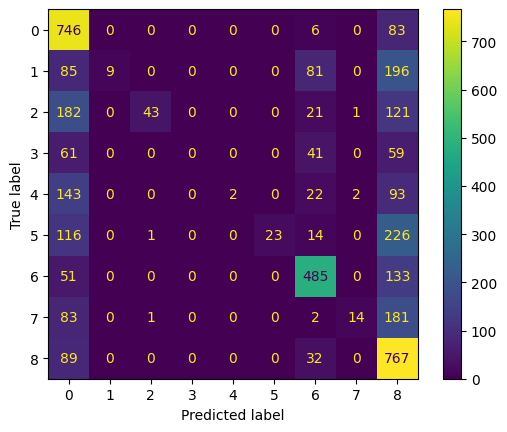

In [23]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestrf_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestrf_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestrf_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.5048635824436536
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       805
           2       0.00      0.00      0.00      1282
           3       0.50      1.00      0.67      2128

    accuracy                           0.50      4215
   macro avg       0.17      0.33      0.22      4215
weighted avg       0.25      0.50      0.34      4215



C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


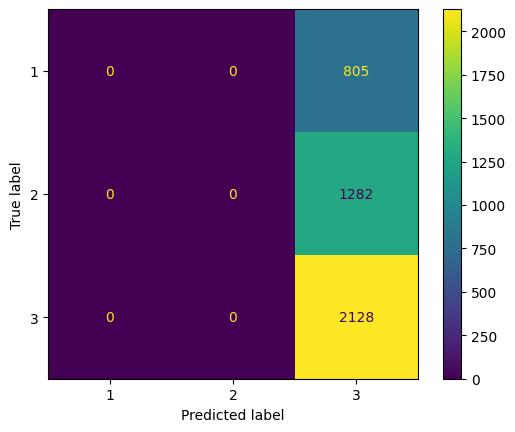

In [24]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestrf_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestrf_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestrf_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [25]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"rf_20240720_1.pkl"), "wb") as f:
    dump(bestrf, f, protocol=5)